Importing Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer



In [ ]:
path = "/content/drive/MyDrive/network_anomaly.csv"
data = pd.read_csv(path, low_memory=False)
data = data.drop(columns = ['Source Port'])
data = data.drop(columns = ['Destination Port'])
data.head()

,Time,Source,Destination,Protocol,Length,bad_packet
0,0.000000,VMware_8a:60:5f,Broadcast,ARP,60,0
1,0.081233,VMware_8a:12:84,Broadcast,ARP,60,0
2,0.217863,VMware_8a:7e:e9,Broadcast,ARP,60,0
3,0.419426,VMware_8a:b2:34,Broadcast,ARP,60,0
4,0.559886,VMware_8a:4e:1c,Broadcast,ARP,60,0


In [ ]:
for dat in data.columns:
  if(data[dat].isnull()).sum() > 0:
    data = data.drop(columns=[dat])

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3245180 entries, 0 to 3245179
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   Time         float64
 1   Source       object 
 2   Destination  object 
 3   Protocol     object 
 4   Length       int64  
 5   bad_packet   int64  
dtypes: float64(1), int64(2), object(3)
memory usage: 148.6+ MB


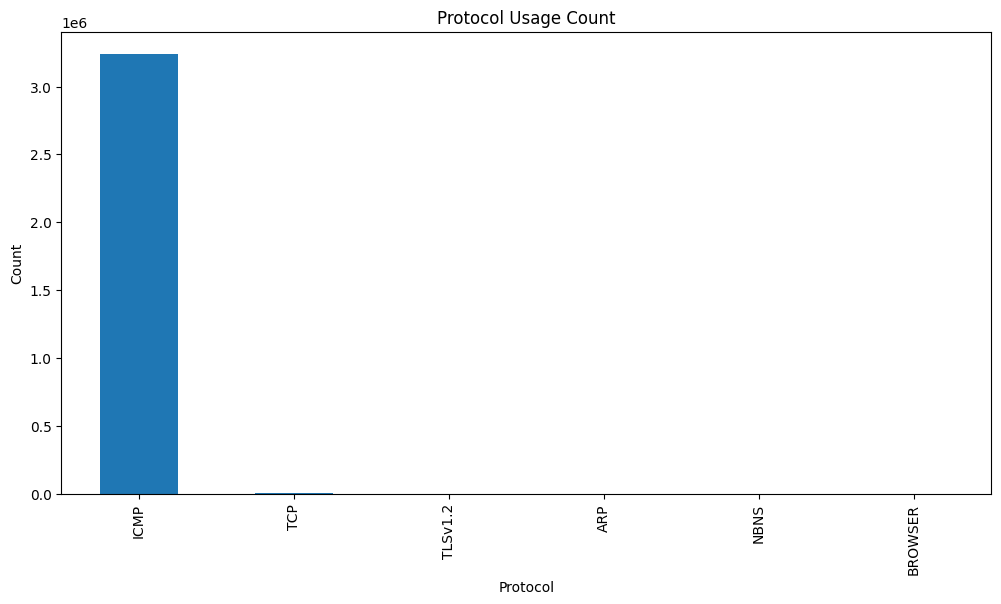

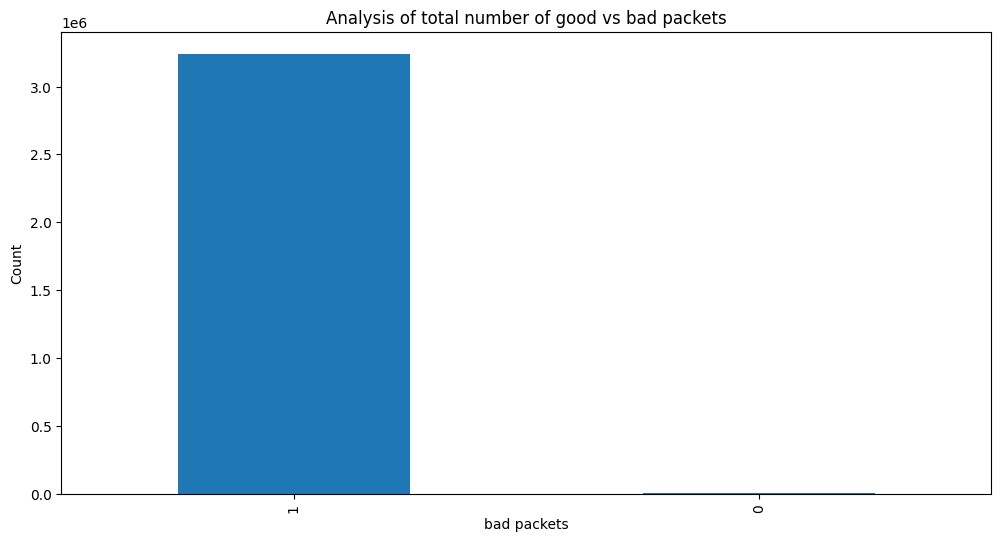

In [ ]:
protocol_counts = data['Protocol'].value_counts()

protocol_counts.plot(kind='bar', figsize=(12, 6))
plt.xlabel("Protocol")
plt.ylabel("Count")
plt.title("Protocol Usage Count")
plt.show()

#Count 0's and 1's for binary classification

ones_and_zeros = data['bad_packet'].value_counts()
ones_and_zeros.plot(kind='bar', figsize=(12, 6))
plt.xlabel("bad packets")
plt.ylabel("Count")
plt.title("Analysis of total number of good vs bad packets")
plt.show()



In [ ]:
training_data, validation_data, testing_data = np.split(data.sample(frac=1), [int(0.6*len(data)), int(0.8*len(data))])

x_train_data = training_data[training_data.columns[:-1]]
y_train_data = training_data[training_data.columns[-1]]
print(y_train_data.value_counts())  # Verify class balance after SMOTE

x_validation_data = validation_data[validation_data.columns[:-1]]
y_validation_data = validation_data[validation_data.columns[-1]]

X_test_data = testing_data[testing_data.columns[:-1]]
y_test_data = testing_data[testing_data.columns[-1]]

textColumns = ['Source', 'Destination', 'Protocol']
oneHotEncoder = OneHotEncoder(handle_unknown='ignore')
transformer = ColumnTransformer([("one_hot", oneHotEncoder, textColumns)], remainder="passthrough")
new_x_train = transformer.fit_transform(x_train_data)
new_x_val = transformer.transform(x_validation_data)
new_x_test = transformer.transform(X_test_data)


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


bad_packet
1    1944377
0       2731
Name: count, dtype: int64


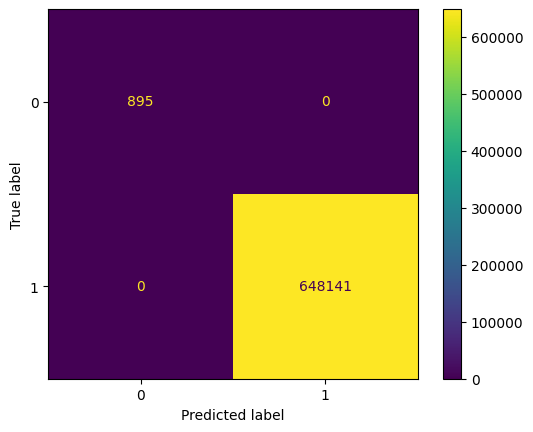

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       895
           1       1.00      1.00      1.00    648141

    accuracy                           1.00    649036
   macro avg       1.00      1.00      1.00    649036
weighted avg       1.00      1.00      1.00    649036



In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics

forest_class_model = RandomForestClassifier(n_estimators=8, random_state=77)
forest_class_model.fit(new_x_train, y_train_data)

y_pred_forest = forest_class_model.predict(new_x_test)
confusion = confusion_matrix(y_test_data, y_pred_forest)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion, display_labels = [0, 1])
cm_display.plot()
plt.show()
print(classification_report(y_test_data, y_pred_forest))

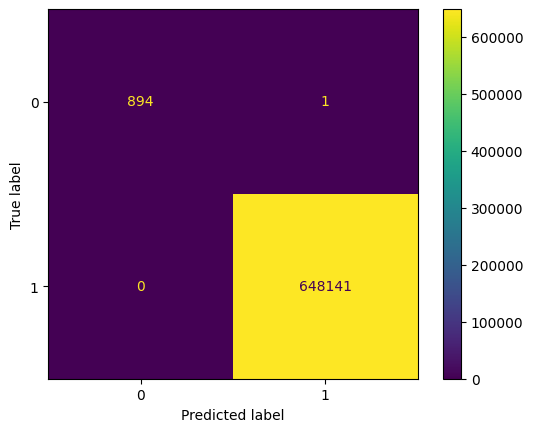

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       895
           1       1.00      1.00      1.00    648141

    accuracy                           1.00    649036
   macro avg       1.00      1.00      1.00    649036
weighted avg       1.00      1.00      1.00    649036



In [ ]:
logistic_model = LogisticRegression()
logistic_model.fit(new_x_train, y_train_data)

y_pred_logistic = logistic_model.predict(new_x_test)
confusion = confusion_matrix(y_true = y_test_data, y_pred = y_pred_logistic)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion, display_labels = [0, 1])
cm_display.plot()
plt.show()
print(classification_report(y_test_data, y_pred_logistic))



**Oversampling data using SMOTE**

bad_packet
1    1944377
0    1944377
Name: count, dtype: int64


<Axes: xlabel='bad_packet'>

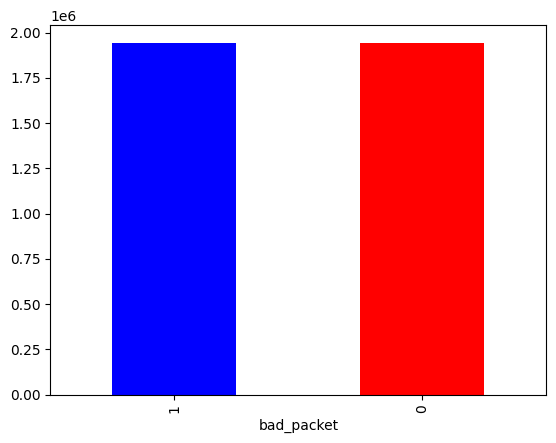

In [ ]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy='minority')
new_x_train_smote, new_y_train_smote = smote.fit_resample(new_x_train, y_train_data)
print(new_y_train_smote.value_counts())
new_y_train_smote.value_counts().plot(kind='bar', color = ["blue", "red"])

**Training the models after oversampling the data**

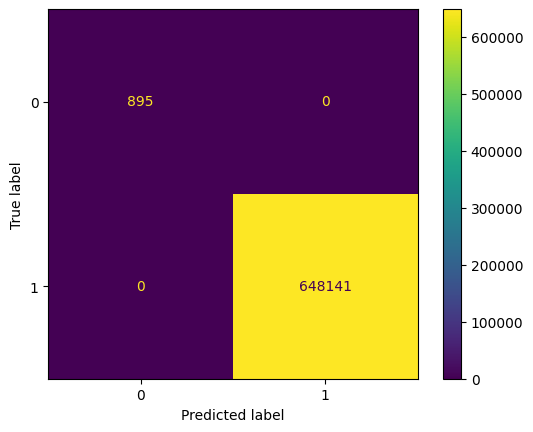

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       895
           1       1.00      1.00      1.00    648141

    accuracy                           1.00    649036
   macro avg       1.00      1.00      1.00    649036
weighted avg       1.00      1.00      1.00    649036



In [ ]:
# Random Forest Classifier

forest_model = RandomForestClassifier(n_estimators=8, random_state=77)
forest_model.fit(new_x_train_smote, new_y_train_smote)

new_y_pred_forest = forest_model.predict(new_x_test)
confusion = confusion_matrix(y_test_data, new_y_pred_forest)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion, display_labels = [0, 1])
cm_display.plot()
plt.show()
print(classification_report(y_test_data, y_pred_forest))

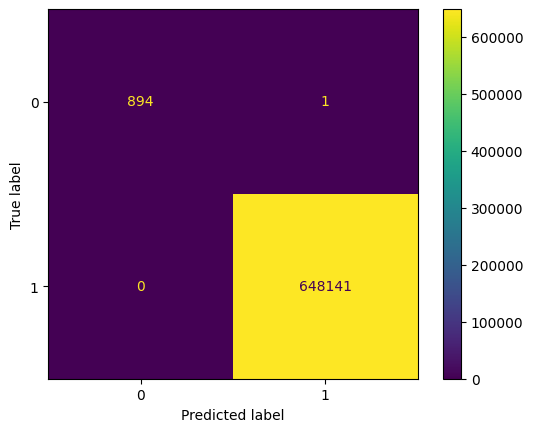

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       895
           1       1.00      1.00      1.00    648141

    accuracy                           1.00    649036
   macro avg       1.00      1.00      1.00    649036
weighted avg       1.00      1.00      1.00    649036



In [ ]:
logistic_regression_model = LogisticRegression()
logistic_regression_model.fit(new_x_train, y_train_data)

y_pred_logistic = logistic_regression_model.predict(new_x_test)
confusion = confusion_matrix(y_true = y_test_data, y_pred = y_pred_logistic)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion, display_labels = [0, 1])
cm_display.plot()
plt.show()
print(classification_report(y_test_data, y_pred_logistic))


In [ ]:
import joblib

joblib.dump(forest_model, 'forest_model_jlib')
joblib.dump(logistic_regression_model, 'logistic_regression_model_jlib')

model_forest = joblib.load('forest_model_jlib')
model_logistic = joblib.load('logistic_regression_model_jlib')
